In [40]:
import qutip as qt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from qutip import Qobj, wigner
import time
import os

#tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

In [4]:
# Utility functions
def get_vacuum_state_tf(dim):
    vacuum_state = qt.basis(dim, 0)
    return tf.convert_to_tensor(vacuum_state.full(), dtype=tf.complex64)

def tf_annihilation(dim):
    diag_vals = tf.math.sqrt(tf.cast(tf.range(1, dim), dtype=tf.float32))
    diag_vals = tf.cast(diag_vals, dtype=tf.complex64)
    return tf.linalg.diag(diag_vals, k=1)

def tf_number(dim):
    diag_vals = tf.range(0.0, dim, dtype=tf.float32)
    diag_vals = tf.cast(diag_vals, dtype=tf.complex64)
    return tf.linalg.diag(diag_vals)

def tf_displacement_operator(dim, alpha):
    alpha = tf.cast(alpha, dtype=tf.complex64)
    a = tf_annihilation(dim)
    term1 = alpha * tf.linalg.adjoint(a)
    term2 = tf.math.conj(alpha) * a
    D = tf.linalg.expm(term1 - term2)
    return D

def tf_displacement_encoding(dim, alpha_vec):
    alpha_vec = tf.cast(alpha_vec, dtype=tf.complex64)
    num = tf.shape(alpha_vec)[0]
    a = tf_annihilation(dim)
    term1 = tf.linalg.adjoint(a)
    term2 = a
    term1_batch = tf.tile(tf.expand_dims(term1, 0), [num, 1, 1])
    term2_batch = tf.tile(tf.expand_dims(term2, 0), [num, 1, 1])
    alpha_vec = tf.reshape(alpha_vec, [-1, 1, 1])
    D = tf.linalg.expm(alpha_vec * term1_batch - tf.math.conj(alpha_vec) * term2_batch)
    return D

def tf_rotation_operator(dim, theta):
    theta = tf.cast(theta, dtype=tf.complex64)
    n = tf_number(dim)
    R = tf.linalg.expm(-1j * theta * n)
    return R

def tf_squeezing_operator(dim, r):
    r = tf.cast(r, dtype=tf.complex64)
    a = tf_annihilation(dim)
    term1 = r * tf.linalg.adjoint(a) * a
    term2 = tf.math.conj(r) * a * tf.linalg.adjoint(a)
    S = tf.linalg.expm(0.5 * (term1 - term2))
    return S

def tf_kerr_operator(dim, kappa):
    kappa = tf.cast(kappa, dtype=tf.complex64)
    n = tf_number(dim)
    K = tf.linalg.expm(1j * kappa * n * n)
    return K

In [5]:
# TensorFlow Custom Layer for Quantum Encoding
class QuantumEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, dim, vacuum_state, **kwargs):
        super(QuantumEncodingLayer, self).__init__(**kwargs)
        self.dim = dim
        self.vacuum_state = vacuum_state

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        batch_vacuum_state = tf.tile(tf.expand_dims(self.vacuum_state, axis=0), [batch_size, 1, 1])
        batch_displacement_operators = tf_displacement_encoding(self.dim, inputs)
        displaced_states = tf.einsum('bij,bjk->bik', batch_displacement_operators, batch_vacuum_state)
        return displaced_states

In [6]:
# TensorFlow Custom Layer for Quantum Transformations
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, dim, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.dim = dim

    def build(self, input_shape):
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed = 42)
        self.theta_1 = self.add_weight("theta_1", shape=[1,], initializer=initializer, trainable=True)
        self.theta_2 = self.add_weight("theta_2", shape=[1,], initializer=initializer, trainable=True)
        self.r = self.add_weight("r", shape=[1,], initializer=initializer, trainable=True)
        self.b = self.add_weight("b", shape=[1,], initializer=initializer, trainable=True)
        self.kappa = self.add_weight("kappa", shape=[1,], initializer=initializer, trainable=True)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # Compute operator tensors dynamically based on the current trainable variables
        D_tensor = tf.expand_dims(tf_displacement_operator(self.dim, self.b), 0)
        R_tensor_1 = tf.expand_dims(tf_rotation_operator(self.dim, self.theta_1), 0)
        S_tensor = tf.expand_dims(tf_squeezing_operator(self.dim, self.r), 0)
        R_tensor_2 = tf.expand_dims(tf_rotation_operator(self.dim, self.theta_2), 0)
        K_tensor = tf.expand_dims(tf_kerr_operator(self.dim, self.kappa), 0)

        # Tile the operator tensors for batch processing
        D_tensor = tf.tile(D_tensor, [batch_size, 1, 1])
        R_tensor_1 = tf.tile(R_tensor_1, [batch_size, 1, 1])
        S_tensor = tf.tile(S_tensor, [batch_size, 1, 1])
        R_tensor_2 = tf.tile(R_tensor_2, [batch_size, 1, 1])
        K_tensor = tf.tile(K_tensor, [batch_size, 1, 1])

        transformed_state = tf.einsum('bij,bjk->bik', R_tensor_1, inputs)
        transformed_state = tf.einsum('bij,bjk->bik', S_tensor, transformed_state)
        transformed_state = tf.einsum('bij,bjk->bik', R_tensor_2, transformed_state)
        transformed_state = tf.einsum('bij,bjk->bik', D_tensor, transformed_state)
        
        activated_state = tf.einsum('bij,bjk->bik', K_tensor, transformed_state)
        return activated_state

In [7]:
# TensorFlow Custom Layer for Quantum Decoding
class QuantumDecodingLayer(tf.keras.layers.Layer):
    def __init__(self, dim, **kwargs):
        super(QuantumDecodingLayer, self).__init__(**kwargs)
        self.dim = dim
        self.x_operator = self.build_x_operator()

    def build_x_operator(self):
        a = tf_annihilation(self.dim)
        x_operator = (a + tf.linalg.adjoint(a)) / 2.0
        x_operator = tf.expand_dims(x_operator, axis=0)  # Add batch dimension
        return x_operator

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        batch_x_operator = tf.tile(self.x_operator, [batch_size, 1, 1])

        # Step 1: Compute \hat{O} | \psi \rangle for each state in the batch
        operator_applied_state = tf.einsum('bij,bjk->bik', batch_x_operator, inputs)

        # Take the complex conjugate of each state and adjust dimensions
        conj_inputs = tf.math.conj(inputs)  # Shape: (batch_size, dim, 1)
        conj_inputs_adj = tf.transpose(conj_inputs, perm=[0, 2, 1])  # Shape: (batch_size, 1, dim)

        # Compute the expectation value (inner product) for each state in the batch
        x_expectation = tf.einsum('bij,bjk->bi', conj_inputs_adj, operator_applied_state) 
        x_expectation = tf.squeeze(x_expectation, axis=-1)

        return tf.cast(x_expectation, dtype=tf.float32)

In [60]:
class WignerNegativityCallback(tf.keras.callbacks.Callback):
    def __init__(self, quantum_encoding_layer, dim, xvec, pvec, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.quantum_encoding_layer = quantum_encoding_layer
        self.dim = dim
        self.xvec = xvec
        self.pvec = pvec
        self.wigner_negativities = []

    def compute_negativity(self, state_ket_array):
        state_ket_reshaped = state_ket_array.squeeze()
        state_ket = Qobj(state_ket_reshaped).unit()  # Convert to Qobj
        wigner_func = wigner(state_ket, self.xvec, self.pvec)
        dx = np.full((100,), 0.00403)
        return np.sum(np.abs(wigner_func)*dx) - 1

    def on_epoch_end(self, epoch, logs=None):
        expectation_values = self.model.predict(self.xvec)  # Model's output
        quantum_states = self.quantum_encoding_layer(expectation_values)  # Convert to quantum states
        quantum_states_np = quantum_states.numpy()  # Convert TensorFlow tensor to NumPy array

        # Prepare the states for parallel processing
        state_kets_arrays = [quantum_states_np[i, :, 0] for i in range(quantum_states_np.shape[0])]

        # Use ThreadPoolExecutor to parallelize the computation
        with ThreadPoolExecutor() as executor:
            negativities = list(executor.map(self.compute_negativity, state_kets_arrays))

        # Average negativity over the batch
        avg_negativity = np.mean(negativities)
        self.wigner_negativities.append(avg_negativity)

    def get_wigner_negativities(self):
        return self.wigner_negativities

In [57]:
x = np.linspace(0, 2*np.pi, 100)
np.diff(x)[0]*np.diff(x)[0]

0.004027998939328379

In [63]:
def plot_results(models, histories, quantumness, configs, cutoff, x_data, y_data, y_data_noisy):
    # Figure 1: 6 Fit Plots
    fig1, axes1 = plt.subplots(2, 3, figsize=(15, 10))
    axes1 = axes1.flatten()
    for i, model in enumerate(models):
        y_pred = model.predict(x_data)
        axes1[i].scatter(x_data, y_data_noisy, s=5, label='Noisy Data')
        axes1[i].plot(x_data, y_pred, label='Fitted Curve', color='r')
        axes1[i].plot(x_data, y_data, label='True Curve', color='g')
        axes1[i].legend()
        axes1[i].set_title(f'Model {i+1}')
        
    plt.tight_layout()

    # Figure 2: Loss History Plots
    fig2, axes2 = plt.subplots(1, 2, figsize=(15, 5))
    # Loss for varying cutoff dimension
    for i in range(len(cutoff)):
        axes2[0].plot(histories[i].history['loss'], label=f'Cutoff: {cutoff[i]}')
    axes2[0].set_title('Loss for Varying Cutoff Dimension')
    axes2[0].set_xlabel('Epoch')
    axes2[0].set_ylabel('MSE Loss')
    axes2[0].legend()

    # Loss for varying number of layers
    for i in range(len(configs)):
        axes2[1].plot(histories[i + len(cutoff)].history['loss'], label=f'Layers: {configs[i][0]}')
    axes2[1].set_title('Loss for Varying Number of Layers')
    axes2[1].set_xlabel('Epoch')
    axes2[1].set_ylabel('MSE Loss')
    axes2[1].legend()

    plt.tight_layout()

    # Figure 3: Loss and Validation Loss for Each Model
    fig3, axes3 = plt.subplots(2, 3, figsize=(15, 10))
    axes3 = axes3.flatten()
    for i in range(len(models)):
        axes3[i].plot(histories[i].history['loss'], label='Training Loss')
        axes3[i].plot(histories[i].history['val_loss'], label='Validation Loss')
        axes3[i].set_title(f'Model {i+1} Loss vs Epochs')
        axes3[i].set_xlabel('Epoch')
        axes3[i].set_ylabel('MSE Loss')
        axes3[i].legend()
        
    plt.tight_layout()

    # Figure 4: Quantumness Plot for Each Model
    fig4, ax = plt.subplots(figsize=(10, 6))
    for i, quants in enumerate(quantumness):
        ax.plot(quants, label=f'Model {i+1} Quantumness')

    ax.set_title('Quantumness vs Epochs for All Models')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Wigner Negativity')
    ax.legend()
    
    plt.tight_layout()

    # Save and show all figures
    fig1.savefig('fit.png', facecolor='white')
    fig2.savefig('mses.png', facecolor='white')
    fig3.savefig('mse_with_val.png', facecolor='white')
    fig4.savefig('quantumness.png', facecolor='white')
    plt.show()

In [61]:
# Function for training models with different configurations
def train_models(x_data, y_data_noisy, cutoff_dim = [10], configs = [(6, 50)]):
    trained_models = []
    histories = []
    quantumness = []
    
    if len(cutoff_dim) == 1:
        for num_layers, epochs in configs:
            # Create a new model for each configuration
            vacuum_state = get_vacuum_state_tf(cutoff_dim[0])
            model = tf.keras.Sequential([QuantumEncodingLayer(dim=cutoff_dim[0], vacuum_state=vacuum_state, name='QuantumEncoding')])
            for i in range(num_layers):
                model.add(QuantumLayer(dim=cutoff_dim[0], name=f'QuantumLayer_{i+1}'))
            model.add(QuantumDecodingLayer(dim=cutoff_dim[0], name='QuantumDecoding'))
    
            # Compile and train the model
            model.compile(optimizer='adam', loss='mse')
            print(f'Training model with {num_layers} layers for {epochs} epochs...')
            quantum_encoding_layer = QuantumEncodingLayer(dim=cutoff_dim[0], vacuum_state=get_vacuum_state_tf(cutoff_dim[0]))
            wigner_callback = WignerNegativityCallback(quantum_encoding_layer, dim=cutoff_dim[0], xvec=x_data, pvec=x_data)
            history = model.fit(x_data, y_data_noisy, validation_split=0.33, epochs=epochs, verbose=0, callbacks=wigner_callback)
            print('Training Complete.')
            
            # Store the trained model and its history
            histories.append(history)
            trained_models.append(model)
            quantumness.append(wigner_callback.get_wigner_negativities())
    else:
        for cutoff in cutoff_dim:
            # Create a new model for each configuration
            num_layers, epochs = configs[0]
            vacuum_state = get_vacuum_state_tf(cutoff)
            model = tf.keras.Sequential([QuantumEncodingLayer(dim=cutoff, vacuum_state=vacuum_state, name='QuantumEncoding')])
            for i in range(num_layers):
                model.add(QuantumLayer(dim=cutoff, name=f'QuantumLayer_{i+1}'))
            model.add(QuantumDecodingLayer(dim=cutoff, name='QuantumDecoding'))
    
            # Compile and train the model
            model.compile(optimizer='adam', loss='mse')
            print(f'Training model with {num_layers} layers of {cutoff} dimensions...')
            quantum_encoding_layer = QuantumEncodingLayer(dim=cutoff, vacuum_state=get_vacuum_state_tf(cutoff))
            wigner_callback = WignerNegativityCallback(quantum_encoding_layer, dim=cutoff, xvec=x_data, pvec=x_data)
            history = model.fit(x_data, y_data_noisy, validation_split=0.30, epochs=epochs, verbose=0, callbacks=wigner_callback)
            print('Training Complete.')
    
            # Store the trained model and its history
            histories.append(history)
            trained_models.append(model)
            quantumness.append(wigner_callback.get_wigner_negativities())

    return trained_models, histories, quantumness

Training model with 2 layers for 50 epochs...
4/4 [==============================] - 0s 2ms/step
Training Complete.
Training model with 4 layers for 50 epochs...
4/4 [==============================] - 0s 3ms/step
Training Complete.
Training model with 6 layers for 50 epochs...
4/4 [==============================] - 0s 5ms/step
Training Complete.
Training model with 6 layers of 5 dimensions...
4/4 [==============================] - 0s 4ms/step
Training Complete.
Training model with 6 layers of 10 dimensions...
4/4 [==============================] - 0s 4ms/step
Training Complete.
Training model with 6 layers of 15 dimensions...
4/4 [==============================] - 0s 4ms/step
Training Complete.
4/4 [==============================] - 0s 4ms/step


/usr/lib/python3/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the ima

4/4 [==============================] - 0s 4ms/step


/usr/lib/python3/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the ima

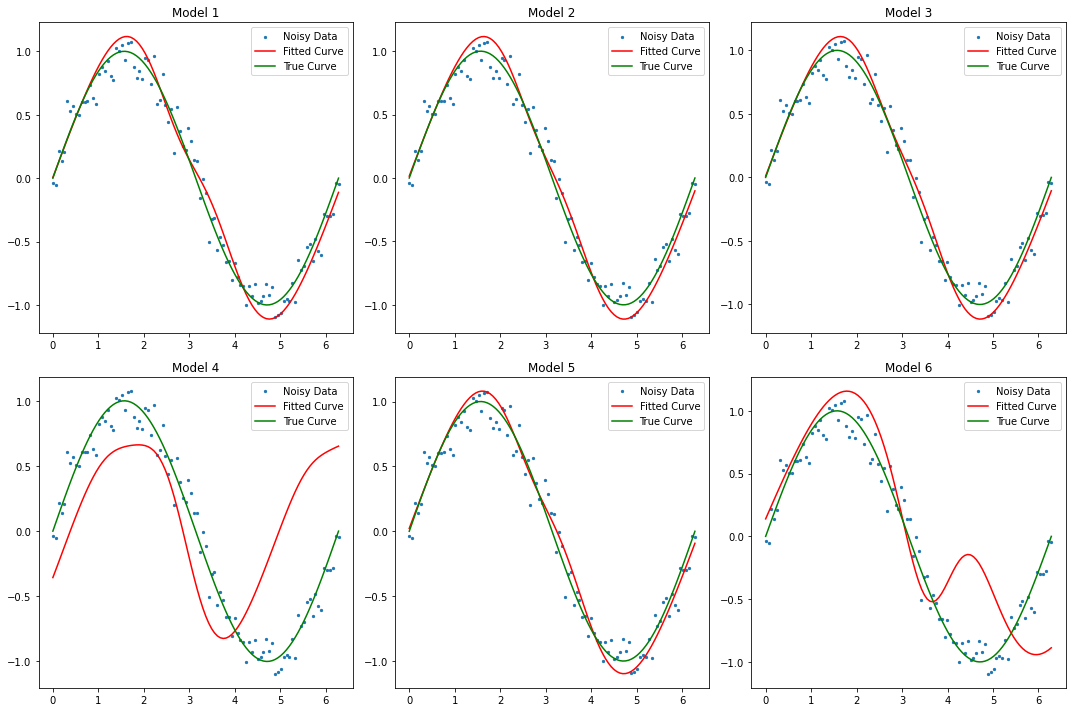

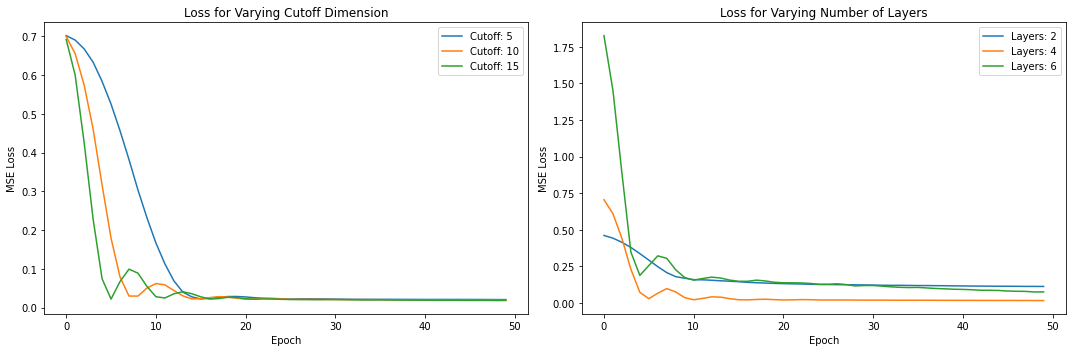

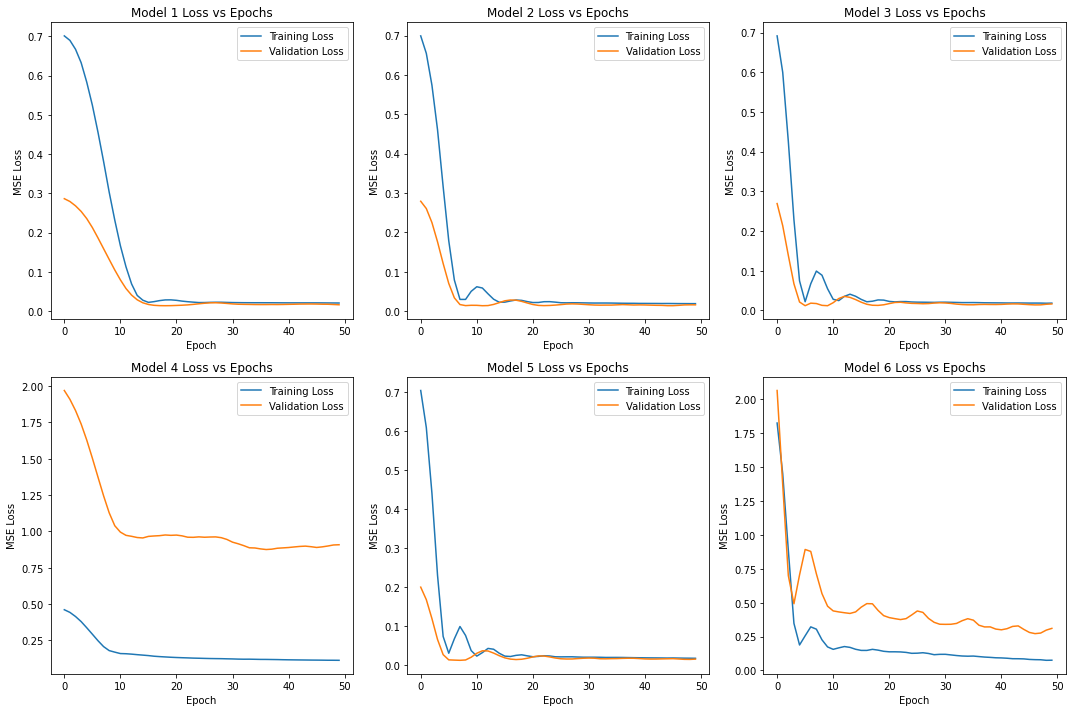

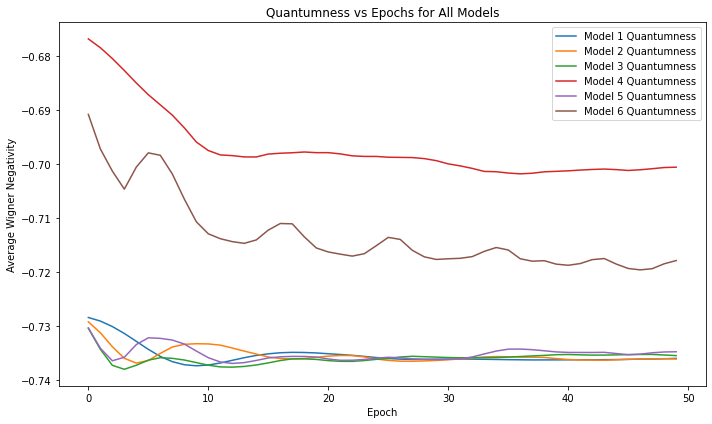

In [64]:
num_layers = 6
cutoff_dim = [5, 10, 15] 

# Generate sine wave data
num_points = 100
x_data = np.linspace(0, 2 * np.pi, num_points)
y_data = np.sin(x_data)

# Add noise
noise_level = 0.1
y_data_noisy = y_data + noise_level * np.random.randn(num_points)

# Reshape for the model
x_data = x_data.astype(np.complex64).reshape(-1, 1)
y_data_noisy = y_data_noisy.astype(np.float32).reshape(-1, 1)

configs = [
    (2, 50),
    (4, 50),
    (6, 50)
]

trained_models, histories, quantumness = train_models(x_data, y_data_noisy, configs = configs)
trained_models2, histories2, quantumness2 = train_models(x_data, y_data_noisy, cutoff_dim = cutoff_dim)

trained_models += trained_models2
histories += histories2
quantumness += quantumness2

plot_results(trained_models, histories, quantumness, configs, cutoff_dim, x_data, y_data, y_data_noisy)